In [ ]:
#Mulitple Choice:
#1. What is a perceptron?
    #It's a neural network with a single layer of input linear neurons followed by an output
    #unit based on the sign(x) function.  It's simplistic but a powerful computational unit. 

#2.What are the different types of perceptrons? Briefly describe each of them.
    #Single layer Perceptron model- All the vectors are conventionally column-vectors;
        #therefore, the dot product WT ·xi transforms the input into a scalar, then the 
        #bias is added, and the binary output is obtained using the step function, which 
        #outputs 1 when z > 0 and 0 otherwise.
        #Based on the Squared Error loss function
    
    #Multi-layered Perceptron model- "Feed forward" 
        #This means that the flow of information begins in the
        #first layer, always proceeds in the same direction, and ends at the output
        #layer. In this case, there are two weight matrices, W and H, and two 
        #corresponding bias vectors, b and c
        #A fundamental condition for any MLP is that at least one hidden-layer activation 
        #function fh(x) is non-linear.


#3. What is a hard margin in a support vector machine model? 
    #Minimal distance from the decision boundary to the training points. It doesn;t
    #allow any points to come inside the margin (liek the soft margin does)

#4. The effectiveness of a support vector machine model depends on:
    #a. Kernal
    
#5. What is/are true about kernel in SVM?
    #d. b and c
        #b. Kernel function map high dimensional data into low dimensional space
        #c. It is a similarity function.

In [13]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC



s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'framingham.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
heart = pd.read_csv(file_content_stream)
heart.head()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [14]:
#Dropping na values
heart = heart.dropna()

In [15]:
#Define the input and target variable
x= heart[['age', 'currentSmoker', 'totChol', 'BMI', 'heartRate']]
y= heart['TenYearCHD']

#Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)

In [16]:
#Scaling
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [17]:
md1_results= list()
md2_results= list()
md3_results= list()
md4_results= list()
for i in range (0,100):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
    
    scaler=MinMaxScaler()
    x_train=scaler.fit_transform(x_train)
    x_test=scaler.fit_transform(x_test)
    
    #First model
    md1= tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim= 5, activation= 'tanh'),
        tf.keras.layers.Dense(2, activation= 'softmax')
    ])
    #define how model will be estimated
    md1.compile(optimizer= 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy']) 
    md1.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes = 2), epochs = 100, batch_size= 500, verbose = 0)    
    #Predicting on the test
    md1_pred= md1.predict(x_test)[:, 1]
    #Setting 15% cut off
    md1_labels = np.where(md1_pred<0.15,0,1)
    #Computing recall on model and appening 
    md1_recall= recall_score(y_test, md1_labels)
    md1_results.append(md1_recall)

    #Second model    
    md2= tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, input_dim= 5, activation= 'relu'), 
        tf.keras.layers.Dense(2, activation= 'softmax')
    ])
    #define how model will be estimated
    md2.compile(optimizer= 'sgd',  loss = 'categorical_crossentropy', metrics= ['accuracy'])
    md2.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes = 2), epochs = 100, batch_size= 500, verbose = 0) 
    #Predicting on the test
    md2_pred= md2.predict(x_test)[:,1]
    #Setting 15% cut off
    md2_labels=np.where(md2_pred<0.15,0,1)
    #Computing recall on model
    md2_recall= recall_score(y_test, md2_labels)
    md2_results.append(md2_recall)
        
        
        
    #Third model (First SNM Model)
    svm_md3= SVC(kernel= 'rbf', probability= True).fit(x_train, y_train)
    #Predicting on the test
    md3_pred= svm_md3.predict_proba(x_test)[:,1]
    #Setting 15% cut off
    md3_labels=np.where(md3_pred<0.15,0,1)
    #Computing recall on model
    md3_recall= recall_score(y_test, md3_labels)
    md3_results.append(md3_recall)
        
        
      
    #Fourth model (Second SNM Model)
    svm_md4= SVC(kernel= 'rbf', probability=True).fit(x_train, y_train)
    #Predicting on the test
    md4_pred= svm_md4.predict_proba(x_test)[:,1]
    #Setting 15% cut off
    md4_labels=np.where(md4_pred<0.15,0,1)
    #Computing recall on model
    md4_recall= recall_score(y_test, md4_labels)
    md4_results.append(md4_recall)    

In [19]:
md3_results

[0.6509433962264151,
 0.4576271186440678,
 0.23741007194244604,
 0.8585858585858586,
 0.6857142857142857,
 0.9357798165137615,
 0.44166666666666665,
 0.5217391304347826,
 0.6521739130434783,
 0.9117647058823529,
 0.9705882352941176,
 0.38461538461538464,
 0.6902654867256637,
 0.7545454545454545,
 0.3208955223880597,
 0.4132231404958678,
 0.7678571428571429,
 0.6666666666666666,
 0.6756756756756757,
 0.8877551020408163,
 0.912621359223301,
 0.6068376068376068,
 0.6517857142857143,
 0.34814814814814815,
 0.4957983193277311,
 0.7592592592592593,
 0.5811965811965812,
 0.6875,
 0.3247863247863248,
 0.36585365853658536,
 0.5126050420168067,
 0.7117117117117117,
 0.7068965517241379,
 0.371900826446281,
 0.6504854368932039,
 0.646551724137931,
 0.7818181818181819,
 0.3821138211382114,
 0.9901960784313726,
 0.20930232558139536,
 0.8260869565217391,
 0.7818181818181819,
 0.7628865979381443,
 0.42735042735042733,
 0.24427480916030533,
 0.7238095238095238,
 0.43410852713178294,
 0.3770491803278688

In [20]:
print('Average Recall for model 1:', np.mean(md1_results))
print('Average Recall for model 2:',np.mean(md2_results))
print('Average Recall for model 3:',np.mean(md3_results))
print('Average Recall for model 4:',np.mean(md4_results))

Average Recall for model 1: 0.5186407120315554
Average Recall for model 2: 0.6598557003759553
Average Recall for model 3: 0.645849086846248
Average Recall for model 4: 0.6449804155621999


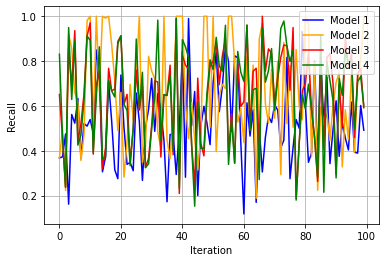

In [21]:
x= [i for i in range(0,100)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.plot(x, md4_results, color = 'green')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4'])
plt.grid()
plt.show();

In [ ]:
#Based on the average recall values for the lists and by looking at the plot, I would use model 2 to predict
#TenYearCHD. Model 2 had the overall highest average and you can see the yellow peaks occuring most often, telling me this model is frequently 
#achieving high recall values. 